In [47]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
from kaolin.metrics.pointcloud import chamfer_distance
from kaolin.ops.mesh import sample_points


import src.shared.util as U
from src.models.blocks import (
     DepthwiseSeparable2d,# as DSC, 
     DownSampleBlock,
     ResidualBlock,
     UpSampleBlock,
     NonLocalBlock,
)
from src.models.vqvae import VQVAE
from src.models.quantizer import Quantizer
from src.models.enricher import Enricher
from src.shared.distancer import MeanDistancer, NeighborDistancer
from src.shared.normals import vertex_normals
from src.shared.faces import make_faces
from src.dataset.cloud_render_dataset import CloudRenderDataset
from torch.utils.data import DataLoader

torch.set_printoptions(sci_mode=False, precision=5)

In [26]:
device = torch.device('cuda')

resolution = (160, 160) # () Don't render anything (160, 160)
stl_root =  './data/face_stls/'
coarse_root = None # './data/chamfer_fitted/16x16/'
fine_root = './data/chamfer_fitted/32x32/'
n_samples = 0
fine_size = 16
bs = 32
export_flip = [1., -1, 1]
# blur = GaussianBlur(3, 0.5)
# laplacian_loss = LaplacianLoss().to(device)
# shell_loss = ShellLoss(levels).to(device)
# sinkhorn_loss = geomloss.SamplesLoss(loss="sinkhorn", p=2, blur=.05)

#if False:
ds = CloudRenderDataset(stl_root, n_samples, device, resolution=resolution, 
    coarse_root=coarse_root, fine_root=fine_root)
loader = DataLoader(ds, bs, shuffle=True)
batch = next(iter(loader))
enricher = Enricher(0).to(device)
for key in batch:
    print(key, batch[key].shape)
f"{batch['fine'].shape=}" #, f"{batch['cloud'].shape=}"   

img torch.Size([32, 3, 160, 160])
colors torch.Size([32, 1, 3])
directions torch.Size([32, 3, 1])
views torch.Size([32, 1, 4, 4])
fine torch.Size([32, 3, 32, 32])


"batch['fine'].shape=torch.Size([32, 3, 32, 32])"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


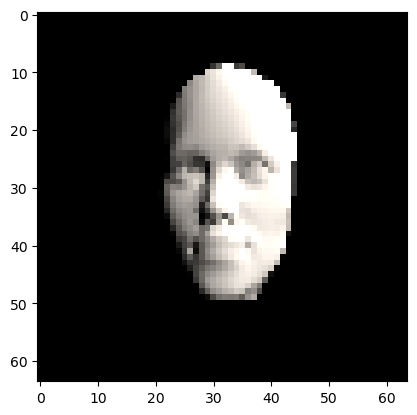

In [45]:
import torchvision.transforms as transforms
import  src.shared.transforms as T

#img = transforms.Normalize()(batch['img'][6])
img#.save('./0.png')
import matplotlib.pyplot as plt
plt.imshow(T.channel_last(F.interpolate(batch['img'], 64, mode='bicubic'))[4])

In [3]:
from src.dataset.blend_dataset import BlendDataset, blend_transform, barebone_transform

batch_size = 64
export_flip = [1., -1, 1]

#device = torch.device(args.device)
grid_root = './data/chamfer_fitted/32x32/'
#grid_root = './data/chamfer_fitted/16x16/'
#ds = BlendDataset(grid_root, device=device, transform=blend_transform)
ds = BlendDataset(grid_root, device=device, transform=barebone_transform)
loader = DataLoader(ds, batch_size, shuffle=True)
next(iter(loader)).shape

torch.Size([64, 3, 32, 32])

In [40]:
num_training_updates = 15001
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
embedding_dim = 64  # 64
num_embeddings = 512 # 512
commitment_cost = 0.25
decay = 0.99
learning_rate = 0.0003

#loader = DataLoader(ds, batch_size, shuffle=True, pin_memory=True)

vqvae = VQVAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

#optimizer = torch.optim.AdamW(vqvae.parameters(), lr=learning_rate)
#
vqvae.load_state_dict(torch.load('./data/vqvae_512_64_32x32_15000.pth'))

<All keys matched successfully>

In [59]:
from src.models.vqvae import ResidualStack

class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, embedding_dim):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2a = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)

    def forward(self, inputs):        
        x = F.relu(self._conv_1(inputs))
        x = F.relu(self._conv_2(x))        
        x = F.relu(self._conv_2a(x))        
        
        x = self._conv_3(x)
        x = self._residual_stack(x)
        return self._pre_vq_conv(x)

encoder = Encoder(3, num_hiddens,num_residual_layers, 
                  num_residual_hiddens, embedding_dim).to(device)
optimizer = torch.optim.AdamW(encoder.parameters(), lr=learning_rate)
encoder(torch.randn(5, 3, 64, 64, device=device)).shape

torch.Size([5, 64, 8, 8])

In [66]:
params = (list(vqvae.quantizer.parameters()) 
          + list(vqvae._decoder.parameters()) 
          + list(encoder.parameters()))

optimizer = torch.optim.AdamW(params, lr=learning_rate)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0.01
)

In [67]:
vqvae.train()
train_res_recon_error = []
train_res_perplexity = []
train_res_z_error = []
#train_res_chamfer_error = []

src_faces  = U.make_faces(32, device=device)

i =0 
iterator = iter(loader)
while i < num_training_updates:
    i += 1
    batch  = next(iterator, None)
    if batch is None:
        iterator = iter(loader)
        batch  = next(iterator)
    #(data, _) = next(iter(training_loader))    
    img = F.interpolate(batch['img'].to(device), 64, mode='bicubic')
    patch = batch['fine'].to(device)
    #data = batch.to(device)
    #data = F.interpolate(data, 12)
    #cloud_trg = batch['cloud'].to(device)
    optimizer.zero_grad()

    #data_recon, vq_loss, perplexity, quantized = vqvae(data)
    
    z = encoder(img)
    quantized, vq_loss, perplexity, _ = vqvae.quantizer(z)
    patch_recon = vqvae._decoder(quantized)
    recon_error = F.mse_loss(patch_recon, patch)
    
    z_trg = vqvae._encoder(patch)
    z_error =  F.mse_loss(z, z_trg)    
    #src_vertices = U.to_vertices(data_recon)
    #cloud_src, _ = sample_points(src_vertices, src_faces, n_samples)
    #chamfer_error = chamfer_distance(cloud_src, cloud_trg).mean()
    
    loss = recon_error + vq_loss #+ z_error #+ chamfer_error + recon_error * 0.0125
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())    
    train_res_perplexity.append(perplexity.item())
    train_res_z_error.append(z_error.item())
    #train_res_chamfer_error.append(chamfer_error.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.5f' % np.mean(train_res_recon_error[-100:]))      
        #print('chamfer_loss: %.5f' % np.mean(train_res_chamfer_error[-100:]))        
        print('perplexity: %.5f' % np.mean(train_res_perplexity[-100:]))
        print('z_error: %.5f' % np.mean(train_res_z_error[-100:]))
        print()
    if i % 1000 == 0:
        torch.save(vqvae.state_dict(), os.path.join("./data", 
                   f"encoder_{num_embeddings}_{embedding_dim}_32x32_{i}.pth"))

100 iterations
recon_error: 0.00091
perplexity: 35.44140
z_error: 0.00514

200 iterations
recon_error: 0.00055
perplexity: 38.16856
z_error: 0.00496

300 iterations
recon_error: 0.00051
perplexity: 38.32913
z_error: 0.00501

400 iterations
recon_error: 0.00051
perplexity: 38.28760
z_error: 0.00504

500 iterations
recon_error: 0.00051
perplexity: 38.26035
z_error: 0.00506

600 iterations
recon_error: 0.00049
perplexity: 38.35548
z_error: 0.00511

700 iterations
recon_error: 0.00052
perplexity: 38.21838
z_error: 0.00521

800 iterations
recon_error: 0.00049
perplexity: 38.24874
z_error: 0.00523

900 iterations
recon_error: 0.00049
perplexity: 38.26785
z_error: 0.00535

1000 iterations
recon_error: 0.00051
perplexity: 37.98363
z_error: 0.00543

1100 iterations
recon_error: 0.00047
perplexity: 38.34555
z_error: 0.00541

1200 iterations
recon_error: 0.00047
perplexity: 38.56364
z_error: 0.00549

1300 iterations
recon_error: 0.00046
perplexity: 38.48551
z_error: 0.00558

1400 iterations
recon

KeyboardInterrupt: 

In [ ]:
patch_recon.shape, patch.shape

In [71]:
import os
torch.save(vqvae.state_dict(), os.path.join("./data", f"vqvae_1_{num_embeddings}_{embedding_dim}_32x32.pth"))

In [68]:
for i in range(3):
    U.export_stl(patch[i], f'./{i}_orig')
    U.export_stl(patch_recon[i], f'./{i}_reco')
patch.shape

torch.Size([32, 3, 32, 32])

Text(0.5, 0, 'iteration')

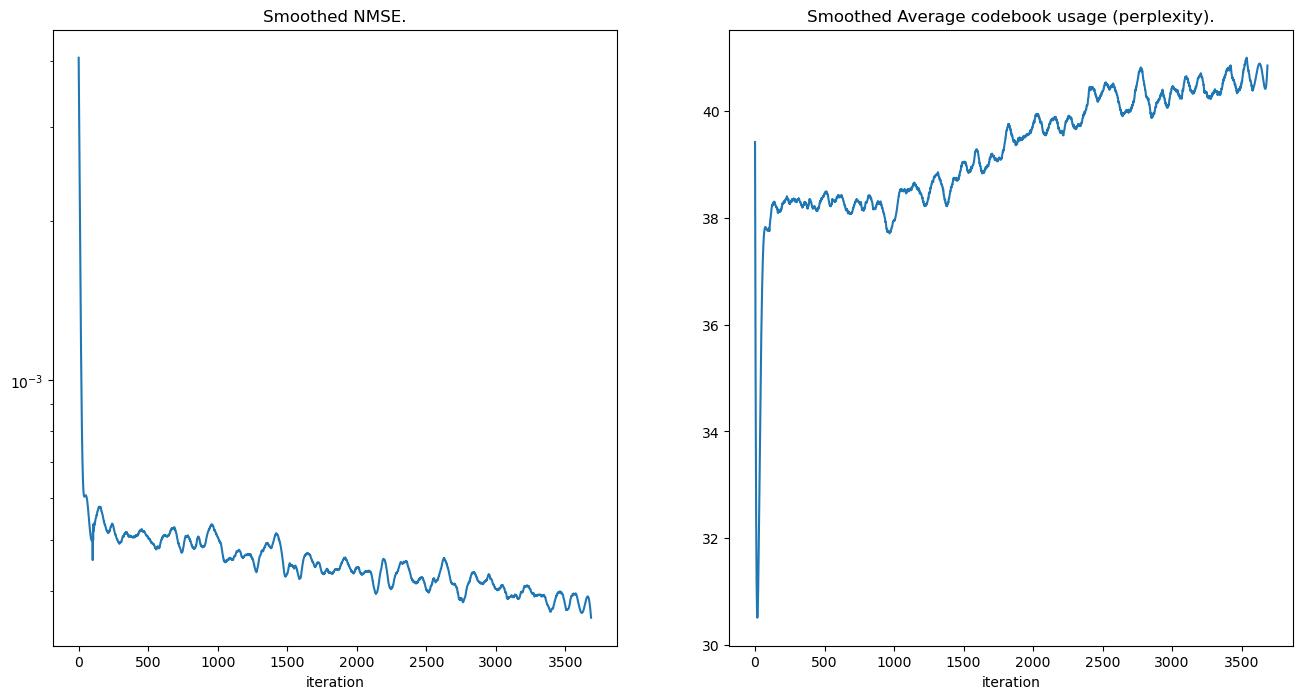

In [69]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

Text(0.5, 0, 'iteration')

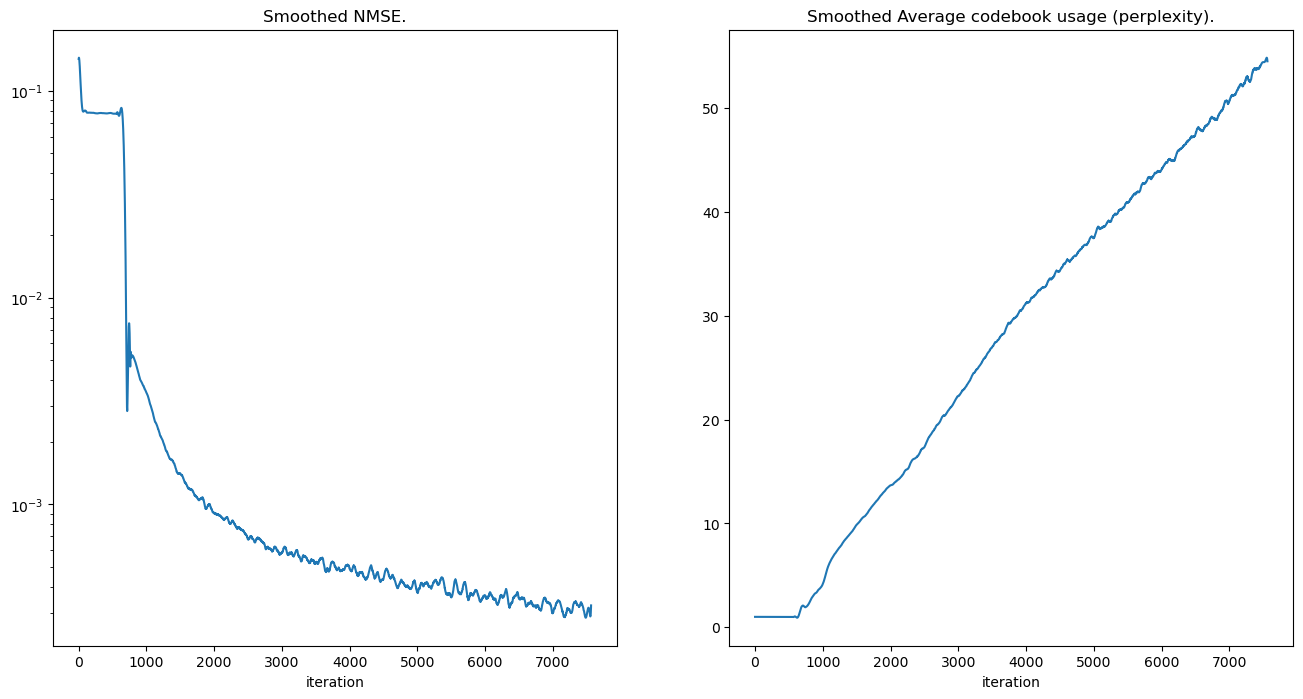

In [11]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

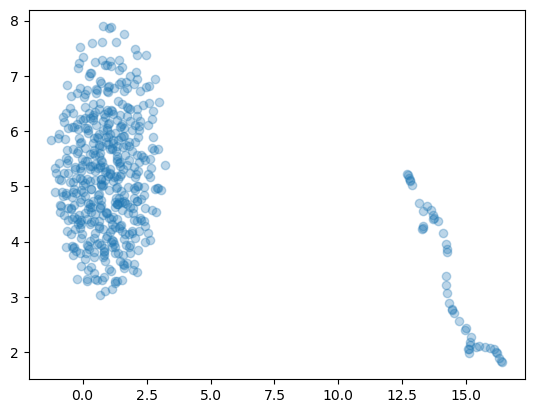

In [70]:
import umap

proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(vqvae.quantizer._embedding.weight.data.cpu())
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)